In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams.update({'font.size': 14})

# Load

In [372]:
sall = pd.read_csv("results_final/stats_by_slots.csv")
sc_agg = pd.read_csv("results_final/stats.csv")
fixed_agg = False
display(sall.head())
display(sc_agg)

,benchmark,compilation id,closure,non-empty,read,used,exact match,widened,narrowed,checkForT,staticT,feedbackT,expectedT,requiredT,optimized away,dependent,polymorphic
0,areWeFast:Bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1
1,areWeFast:Bounce_nonames_simple,0,match,1,1,1,0,1,0,val-,val+,(int|str)-,(int|str)-,val?+,0,0,1
2,areWeFast:Bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0
3,areWeFast:Bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0
4,areWeFast:Bounce_nonames_simple,1,bitwAnd,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,1,0


,name,referenced,referenced non-empty,read non-empty,used,unused non-empty,present non-empty,exact match,widened,narrowed,optimized away non-empty,dependent,other reasons unused non-empty,polluted,used polluted,unused polluted,used polluted exact match,used polluted widened,used polluted narrowed,closure version compilations,closure version compilations using some type feedback,referenced non-empty / referenced,read non-empty / referenced,used / referenced,optimized away non-empty / unused non-empty,dependent / unused non-empty,other reasons unused non-empty / unused non-empty,polluted / referenced non-empty,unused polluted / unused non-empty,used polluted / used,used polluted / polluted,used polluted exact match / exact match,used polluted widened / widened,used polluted narrowed / narrowed,used / referenced non-empty
0,areWeFast:Bounce_nonames_simple,264,160,130,12,148,90,7,5,0,58,128,12,16,3,13,0,3,0,11,7,0.781433,0.723844,0.172829,0.293428,0.556005,0.356146,0.220293,0.172798,0.333333,0.333333,0.000000,0.750000,0.000000,0.204793
1,shootout:binarytrees/binarytrees_naive,1070,341,314,83,258,208,56,27,0,50,213,35,72,21,51,4,17,0,22,13,0.565916,0.516544,0.113918,0.227594,0.606639,0.303119,0.205200,0.180770,0.336752,0.322500,0.074592,0.690476,0.000000,0.242096
2,shootout:knucleotide/knucleotide,1493,809,754,148,661,508,89,59,0,153,517,86,71,12,59,0,12,0,59,33,0.711240,0.676019,0.117276,0.316383,0.555019,0.258140,0.108234,0.087246,0.177082,0.223333,0.000000,0.252232,0.000000,0.164559
3,shootout:fasta/fasta_naive_2,598,343,299,73,270,161,44,29,0,109,225,30,23,5,18,0,5,0,17,11,0.742709,0.681099,0.126782,0.267390,0.565152,0.348531,0.088382,0.060171,0.164773,0.236607,0.000000,0.247619,0.000000,0.171056
4,shootout:fannkuch/fannkuchredux,251,184,167,5,179,70,4,1,0,109,163,9,6,1,5,0,1,0,6,3,0.701663,0.646953,0.082908,0.513308,0.619899,0.216717,0.120922,0.087626,0.333333,0.166667,0.000000,1.000000,0.000000,0.109883
5,shootout:pidigits/pidigits,5710,2808,2733,1010,1798,1251,664,345,1,547,1652,107,692,326,366,38,288,0,93,81,0.613532,0.592256,0.229893,0.294839,0.800287,0.164748,0.293669,0.304429,0.314992,0.475537,0.043059,0.754154,0.000000,0.373666
6,shootout:fannkuch/fannkuchredux_naive,244,164,146,3,161,54,2,1,0,107,145,9,6,1,5,0,1,0,5,2,0.719555,0.655320,0.065091,0.508877,0.524185,0.271241,0.151487,0.109877,0.500000,0.166667,0.000000,1.000000,0.000000,0.066259
7,areWeFast:Mandelbrot,358,280,225,24,256,130,14,10,0,126,233,15,19,4,15,0,4,0,14,9,0.843402,0.799469,0.161456,0.205107,0.689372,0.224434,0.209424,0.170797,0.194444,0.218750,0.000000,0.388889,0.000000,0.196470
8,RealThing:flexclust_no_s4,5402,2527,2314,714,1813,1271,533,180,1,542,1505,196,250,58,192,8,49,1,144,95,0.612601,0.582819,0.159203,0.301984,0.496611,0.348985,0.165847,0.146125,0.205002,0.244369,0.043872,0.347712,1.000000,0.267262
9,kaggle:titanic,67477,33292,31897,7075,26217,21827,4556,2509,16,4390,20080,5010,6446,1066,5380,280,778,14,2046,1258,0.655210,0.629785,0.115416,0.156575,0.579725,0.358354,0.242709,0.241880,0.219212,0.162564,0.082378,0.384053,0.928571,0.179414


In [373]:
if "benchmark" in sall.columns:
    sall_names_split = sall["benchmark"].str.split(":")
    sall_names_b = sall_names_split.str.get(0)
    sall_names_n = sall_names_split.str.get(1).str.split("/").str[-1].str.lower()

    sall.insert(0, "name", (sall_names_b + ":" + sall_names_n))

    sall.drop("benchmark", axis=1, inplace=True)

In [374]:
if not fixed_agg:
    sc_agg_names = sc_agg["name"].str.split(":")
    sc_agg_names_b = sc_agg_names.str.get(0)
    sc_agg_names_n = sc_agg_names.str.get(1).str.split("/").str[-1].str.lower()

    sc_agg["name"] = sc_agg_names_b + ":" + sc_agg_names_n

    fixed_agg = True

In [375]:
display(sall.head())

,name,compilation id,closure,non-empty,read,used,exact match,widened,narrowed,checkForT,staticT,feedbackT,expectedT,requiredT,optimized away,dependent,polymorphic
0,areWeFast:bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1
1,areWeFast:bounce_nonames_simple,0,match,1,1,1,0,1,0,val-,val+,(int|str)-,(int|str)-,val?+,0,0,1
2,areWeFast:bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0
3,areWeFast:bounce_nonames_simple,0,match,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0
4,areWeFast:bounce_nonames_simple,1,bitwAnd,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,1,0


In [376]:
columns_type = ["checkForT", "staticT", "feedbackT", "expectedT", "requiredT"]

In [377]:

if "referenced" not in sall.columns:
    sall.insert(3, "referenced", pd.Series(1, index=sall.index))

if "closure" in sall.columns:
    sall.drop("closure", axis=1, inplace=True)

if "non-empty" in sall.columns:
    sall.rename(columns={"non-empty": "referenced non-empty"}, inplace=True)

In [378]:
# Add columns
sall_ne = sall["referenced non-empty"]

# Non-empty
sall["read non-empty"] = sall["read"] & sall_ne
assert (((sall["used"] & sall_ne) | (sall["used"] ^ 1))).all()

# Unused
sall["unused"] = sall["used"] ^ 1
sall["unused non-empty"] = sall["unused"] & sall_ne

sall["optimized away non-empty"] = sall["optimized away"] & sall_ne
# Fix dependent, TODO: turn to assert
sall["dependent"] = sall["dependent"] & sall_ne
sall["other reason unused non-empty"] = sall["unused"] & sall_ne & (sall["optimized away"] ^ 1) & (sall["dependent"] ^ 1)
sall["optimized away dependent"] = sall["optimized away non-empty"] & sall["dependent"]

# Used
sall["polymorphic used"] = sall["used"] & sall["polymorphic"]
sall["polymorphic exact match"] = sall["exact match"] & sall["polymorphic"]
sall["polymorphic widened"] = sall["widened"] & sall["polymorphic"]
sall["polymorphic narrowed"] = sall["narrowed"] & sall["polymorphic"]

# Unused polymorphic
sall["polymorphic unused"] = sall["unused"] & sall["polymorphic"]
sall["polymorphic optimized away non-empty"] = sall["optimized away non-empty"] & sall["polymorphic"]
sall["polymorphic dependent"] = sall["dependent"] & sall["polymorphic"]
sall["polymorphic other reason unused non-empty"] = sall["other reason unused non-empty"] & sall["polymorphic"]

sall["monomorphic"] = (sall["polymorphic"] ^ 1) & sall_ne

# Used monomorphic
sall["monomorphic used"] = sall["used"] & sall["monomorphic"]
sall["monomorphic exact match"] = sall["monomorphic used"] & sall["exact match"]
sall["monomorphic narrowed"] = sall["monomorphic used"] & sall["narrowed"]
sall["monomorphic widened"] = sall["monomorphic used"] & sall["widened"]

# Unused monomorphic
sall["monomorphic unused"] = sall["unused"] & sall["monomorphic"]
sall["monomorphic optimized away non-empty"] = sall["optimized away non-empty"] & sall["monomorphic"]
sall["monomorphic dependent"] = sall["dependent"] & sall["monomorphic"]
sall["monomorphic other reason unused non-empty"] = sall["other reason unused non-empty"] & sall["monomorphic"]
sall.head()

,name,compilation id,referenced,referenced non-empty,read,used,exact match,widened,narrowed,checkForT,staticT,feedbackT,expectedT,requiredT,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty
0,areWeFast:bounce_nonames_simple,0,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,areWeFast:bounce_nonames_simple,0,1,1,1,1,0,1,0,val-,val+,(int|str)-,(int|str)-,val?+,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,areWeFast:bounce_nonames_simple,0,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
3,areWeFast:bounce_nonames_simple,0,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,areWeFast:bounce_nonames_simple,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,1,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0


In [379]:
stats = sall.drop(columns_type + ["compilation id"], axis=1).groupby("name").sum()

# Split name
stats.reset_index(inplace=True)
stats[["set", "name"]] = stats["name"].str.split(":", expand=True)

# Sort
stats.sort_values(by=["set", "name"], inplace=True, key= lambda x: x.str.lower())

# Set new index
stats.set_index("name", inplace=True)
stats.insert(0, "set", stats.pop("set"))

# move Titanic to end
if "titanic" in stats.index:
    stats = pd.concat([stats.drop("titanic"), stats.loc[["titanic"]]])

stats

,set,referenced,referenced non-empty,read,used,exact match,widened,narrowed,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bounce_nonames_simple,areWeFast,264,160,137,12,7,5,0,162,128,16,130,252,148,58,12,50,3,0,3,0,13,2,9,3,144,9,7,0,2,135,56,119,9
mandelbrot,areWeFast,358,280,234,24,14,10,0,204,233,19,225,334,256,126,15,118,4,0,4,0,15,7,7,5,261,20,14,0,6,241,119,226,10
flexclust_no_s4,RealThing,5402,2527,2650,714,533,180,1,3417,1505,250,2314,4688,1813,542,196,430,58,8,49,1,192,75,140,42,2277,656,525,0,131,1621,467,1365,154
volcano,RealThing,2037,507,515,119,107,12,0,1727,354,17,492,1918,388,197,20,183,3,0,3,0,14,2,10,2,490,116,107,0,9,374,195,344,18
binarytrees_naive,shootout,1070,341,452,83,56,27,0,779,213,72,314,987,258,50,35,40,21,4,17,0,51,5,43,6,269,62,52,0,10,207,45,170,29
fannkuchredux,shootout,251,184,169,5,4,1,0,176,163,6,167,246,179,109,9,102,1,0,1,0,5,2,0,3,178,4,4,0,0,174,107,163,6
fannkuchredux_naive,shootout,244,164,146,3,2,1,0,187,145,6,146,241,161,107,9,100,1,0,1,0,5,2,0,3,158,2,2,0,0,156,105,145,6
fasta_naive_2,shootout,598,343,304,73,44,29,0,364,225,23,299,525,270,109,30,94,5,0,5,0,18,9,5,8,320,68,44,0,24,252,100,220,22
knucleotide,shootout,1493,809,816,148,89,59,0,837,517,71,754,1345,661,153,86,95,12,0,12,0,59,12,32,16,738,136,89,0,47,602,141,485,70


# Aggregate

In [380]:
scomps = sall.drop(["checkForT", "staticT", "feedbackT", "expectedT", "requiredT"], axis=1).groupby(["name", "compilation id"]).sum()

scomps.reset_index(inplace=True)
scomps["name"] = scomps["name"].str.split(":", expand=True)[1]

scomps.head()

,name,compilation id,referenced,referenced non-empty,read,used,exact match,widened,narrowed,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty
0,flexclust_no_s4,0,4,4,4,2,0,2,0,1,0,2,4,2,2,1,1,0,2,0,2,0,0,0,0,0,2,0,0,0,0,2,1,0,1
1,flexclust_no_s4,1,8,8,8,2,1,1,0,3,0,4,8,6,6,3,3,0,1,0,1,0,3,1,0,2,4,1,1,0,0,3,2,0,1
2,flexclust_no_s4,2,83,30,23,10,8,2,0,61,14,2,22,73,20,8,4,6,0,0,0,0,2,0,0,2,28,10,8,0,2,18,8,14,2
3,flexclust_no_s4,3,27,21,21,4,1,3,0,8,15,2,21,23,17,2,2,2,1,0,1,0,1,0,1,0,19,3,1,0,2,16,2,14,2
4,flexclust_no_s4,4,3,1,1,0,0,0,0,2,0,0,1,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [381]:
def agg(lhs, rhs):
    res_name = lhs + " / " + rhs
    if res_name not in stats:
        scomps[res_name] = scomps[lhs] / scomps[rhs]
        stats[res_name] = scomps.groupby("name")[res_name].mean()
    return stats[res_name]

agg("referenced non-empty", "referenced")

name
bounce_nonames_simple    0.781433
mandelbrot               0.843402
flexclust_no_s4          0.612601
volcano                  0.551936
binarytrees_naive        0.565916
fannkuchredux            0.701663
fannkuchredux_naive      0.719555
fasta_naive_2            0.742709
knucleotide              0.711240
pidigits                 0.613532
titanic                  0.655210
Name: referenced non-empty / referenced, dtype: float64

In [382]:
def agg_concat(*cols):
    return pd.concat([*cols], axis=1)

# C++ Aggregate

In [383]:
if "set" not in sc_agg.columns:
    sc_agg[["set", "name"]] = sc_agg["name"].str.split(":", expand=True)
    sc_agg.set_index("name", inplace=True)

if "compilations" not in stats.columns:
    stats.insert(1, "compilations",  sc_agg["closure version compilations"])

if "benefited" not in stats.columns:
    stats.insert(2, "benefited",  sc_agg["closure version compilations using some type feedback"])

stats

,set,compilations,benefited,referenced,referenced non-empty,read,used,exact match,widened,narrowed,optimized away,dependent,polymorphic,read non-empty,unused,unused non-empty,optimized away non-empty,other reason unused non-empty,optimized away dependent,polymorphic used,polymorphic exact match,polymorphic widened,polymorphic narrowed,polymorphic unused,polymorphic optimized away non-empty,polymorphic dependent,polymorphic other reason unused non-empty,monomorphic,monomorphic used,monomorphic exact match,monomorphic narrowed,monomorphic widened,monomorphic unused,monomorphic optimized away non-empty,monomorphic dependent,monomorphic other reason unused non-empty,referenced non-empty / referenced
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bounce_nonames_simple,areWeFast,11,7,264,160,137,12,7,5,0,162,128,16,130,252,148,58,12,50,3,0,3,0,13,2,9,3,144,9,7,0,2,135,56,119,9,0.781433
mandelbrot,areWeFast,14,9,358,280,234,24,14,10,0,204,233,19,225,334,256,126,15,118,4,0,4,0,15,7,7,5,261,20,14,0,6,241,119,226,10,0.843402
flexclust_no_s4,RealThing,144,95,5402,2527,2650,714,533,180,1,3417,1505,250,2314,4688,1813,542,196,430,58,8,49,1,192,75,140,42,2277,656,525,0,131,1621,467,1365,154,0.612601
volcano,RealThing,23,16,2037,507,515,119,107,12,0,1727,354,17,492,1918,388,197,20,183,3,0,3,0,14,2,10,2,490,116,107,0,9,374,195,344,18,0.551936
binarytrees_naive,shootout,22,13,1070,341,452,83,56,27,0,779,213,72,314,987,258,50,35,40,21,4,17,0,51,5,43,6,269,62,52,0,10,207,45,170,29,0.565916
fannkuchredux,shootout,6,3,251,184,169,5,4,1,0,176,163,6,167,246,179,109,9,102,1,0,1,0,5,2,0,3,178,4,4,0,0,174,107,163,6,0.701663
fannkuchredux_naive,shootout,5,2,244,164,146,3,2,1,0,187,145,6,146,241,161,107,9,100,1,0,1,0,5,2,0,3,158,2,2,0,0,156,105,145,6,0.719555
fasta_naive_2,shootout,17,11,598,343,304,73,44,29,0,364,225,23,299,525,270,109,30,94,5,0,5,0,18,9,5,8,320,68,44,0,24,252,100,220,22,0.742709
knucleotide,shootout,59,33,1493,809,816,148,89,59,0,837,517,71,754,1345,661,153,86,95,12,0,12,0,59,12,32,16,738,136,89,0,47,602,141,485,70,0.711240


# Plot

In [ ]:
def plot(df: pd.DataFrame, index, columns = None,
         title = None, filename = None,
         figsize= (15, 5), colors = None,
         labels = None, legend = None,
         xlabel = None, ylabel = None,
         rotate_xticks=True):
    if columns is None:
        columns = df.columns
    else:
        df = df[columns]

    df = df.copy()
    df.index = index

    ax = df.plot(
        kind="bar",
        width=0.75,
        figsize=figsize,
        color=colors
    )

    if labels == "values":
        labels = [df[col].round(2) for col in columns]

    if labels is not None:
        for container, l in zip(ax.containers, labels):
            ax.bar_label(container, labels=l, label_type="edge", padding=2,fontsize=10)

    if legend is not None:
        plt.legend(legend, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(df.columns))

    if title is not None:
        plt.title(title)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    if rotate_xticks:
        plt.xticks(rotation=45, ha='right')
    else:
        plt.xticks(rotation=0)


    plt.ylim(0, 1.0)

    if filename is not None:
        plt.savefig("./figures/" + filename + ".pdf", bbox_inches='tight')

    plt.show()

In [385]:
figsize_three_cols = (18, 5)

## Usage of slots

AttributeError: 'Axes' object has no attribute 'ylabel'

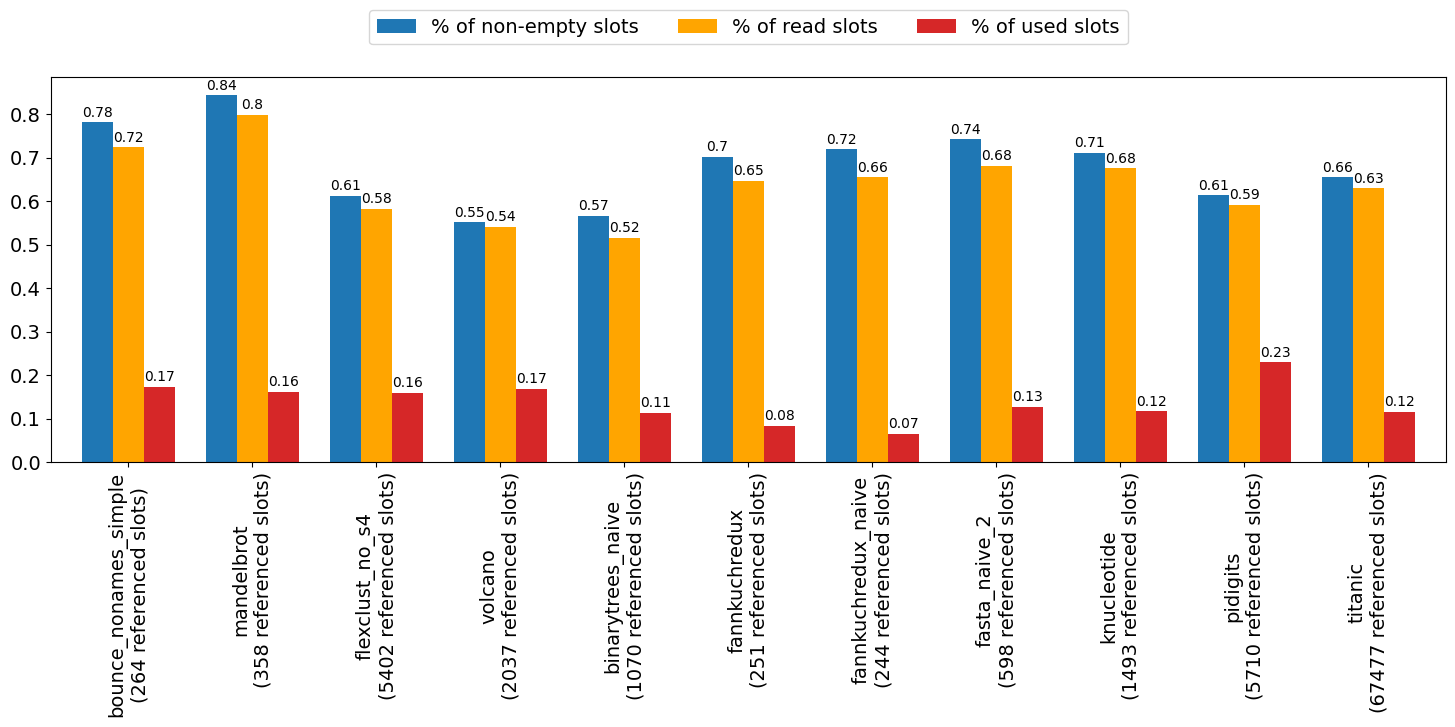

In [386]:
colors_usage =["tab:blue", "orange", "tab:red"]

plot(
    agg_concat(
        agg("referenced non-empty", "referenced"),
        agg("read non-empty", "referenced"),
        agg("used", "referenced")
    ),

    index = stats.index + "\n(" + stats["referenced"].astype(str) + " referenced slots)",

    # title= "Usage of slots across closure compilations",

    colors=colors_usage,

    labels = "values",
    figsize=figsize_three_cols,

    legend=[
        "% of non-empty slots",
        "% of read slots",
        "% of used slots"
    ],

    ylabel="Percentage out of referenced",

    filename="usage_overall"
)

In [ ]:
# plot(
#     agg_concat(
#         (stats["referenced non-empty"] / stats["referenced"]),
#         (stats["read non-empty"] / stats["referenced"]),
#         (stats["used"] / stats["referenced"])
#     ),

#     index = stats.index + "\n(" + stats["referenced"].astype(str) + " referenced slots)",

#     # title= "Usage of slots across closure compilations",

#     colors=colors_usage,

#     labels = [stats["referenced non-empty"], stats["read non-empty"], stats["used"]],
#     figsize=figsize_three_cols,

#     legend=[
#         "% of non-empty slots (referenced non-empty / referenced)",
#         "% of read non-empty slots (read non-empty / referenced)",
#         "% of used non-empty slots (used / referenced)"
#     ],

#     ylabel="Percentage out of referenced",
# )

## Unused

In [ ]:
    cols = [prefix + " " + col for col in cols]
    used_col = prefix + " " + used_colempty / unused non-empty"]]

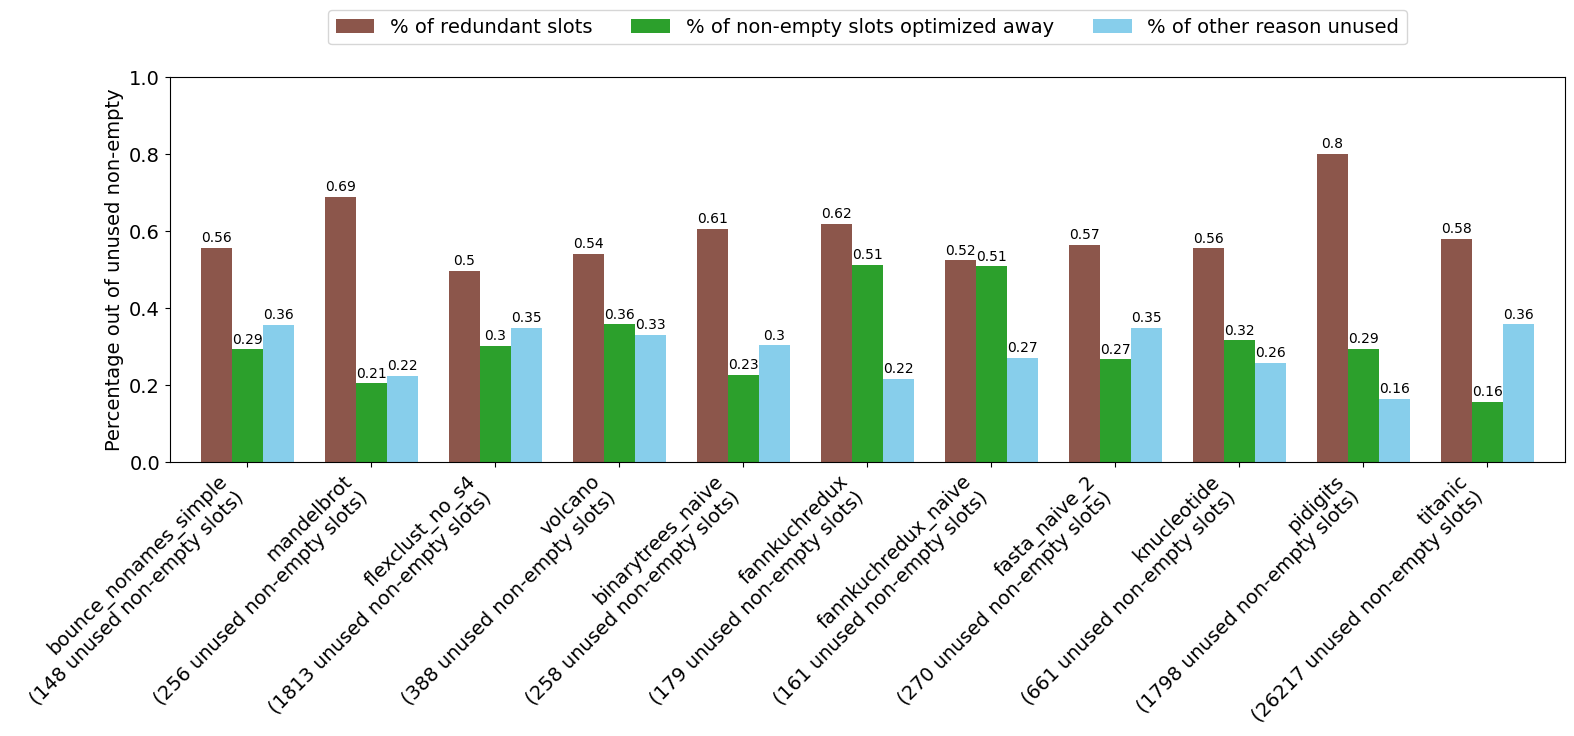

In [ ]:
plot(
    agg_concat(
        agg("dependent", "unused non-empty"),
        agg("optimized away non-empty", "unused non-empty"),
        agg("other reason unused non-empty", "unused non-empty")
    ),

    index = stats.index + "\n(" + stats["unused non-empty"].astype(str) + " unused non-empty slots)",

    # title="Unused non-empty slots",

    colors=[ "tab:brown", "tab:green", "skyblue"],
    figsize=figsize_three_cols,

    labels= "values",
    legend=[
        "% of redundant slots",
        "% of non-empty slots optimized away",
        "% of other reason unused"
    ],

    ylabel="Percentage out of unused non-empty",
    filename="unused"
)

In [ ]:
# plot(
#     agg_concat(
#         agg("polymorphic optimized away non-empty", "polymorphic unused"),
#         agg("polymorphic dependent", "polymorphic unused"),
#         agg("polymorphic other reason unused non-empty", "polymorphic unused")
#     ),

#     index = stats.index + "\n(" + stats["polymorphic unused"].astype(str) + " unused non-empty slots)",

#     # title="Unused non-empty slots",

#     colors=["tab:green", "tab:brown", "skyblue"],
#     figsize=figsize_three_cols,

#     labels= "values",
#     legend=[
#         "% of non-empty slots optimized away",
#         "% of redundant slots",
#         "% of other reason unused"
#     ],

#     ylabel="Percentage out of unused non-empty",
#     # filename="unused"
# )

In [ ]:
# plot(
#     agg_concat(
#         agg("monomorphic optimized away non-empty", "monomorphic unused"),
#         agg("monomorphic dependent", "monomorphic unused"),
#         agg("monomorphic other reason unused non-empty", "monomorphic unused")
#     ),

#     index = stats.index + "\n(" + stats["monomorphic unused"].astype(str) + " unused non-empty slots)",

#     # title="Unused non-empty slots",

#     colors=["tab:green", "tab:brown", "skyblue"],
#     figsize=figsize_three_cols,

#     labels= "values",
#     legend=[
#         "% of non-empty slots optimized away",
#         "% of redundant slots",
#         "% of other reason unused"
#     ],

#     ylabel="Percentage out of unused non-empty",
#     # filename="unused"
# )

## Unused slots

In [ ]:
colors_used = ["cornflowerblue", "tomato", "gold"]

In [ ]:
def compute_used_percentage(prefix=""):
    used_columns = [ prefix + c for c in ["exact match", "widened", "narrowed"]]
    used_columns_perc = [ c + " %" for c in used_columns ]

    for (uc, ucp) in zip(used_columns, used_columns_perc):
        stats[ucp] = stats[uc] / stats[ prefix + "used" ]

    return (used_columns, used_columns_perc)

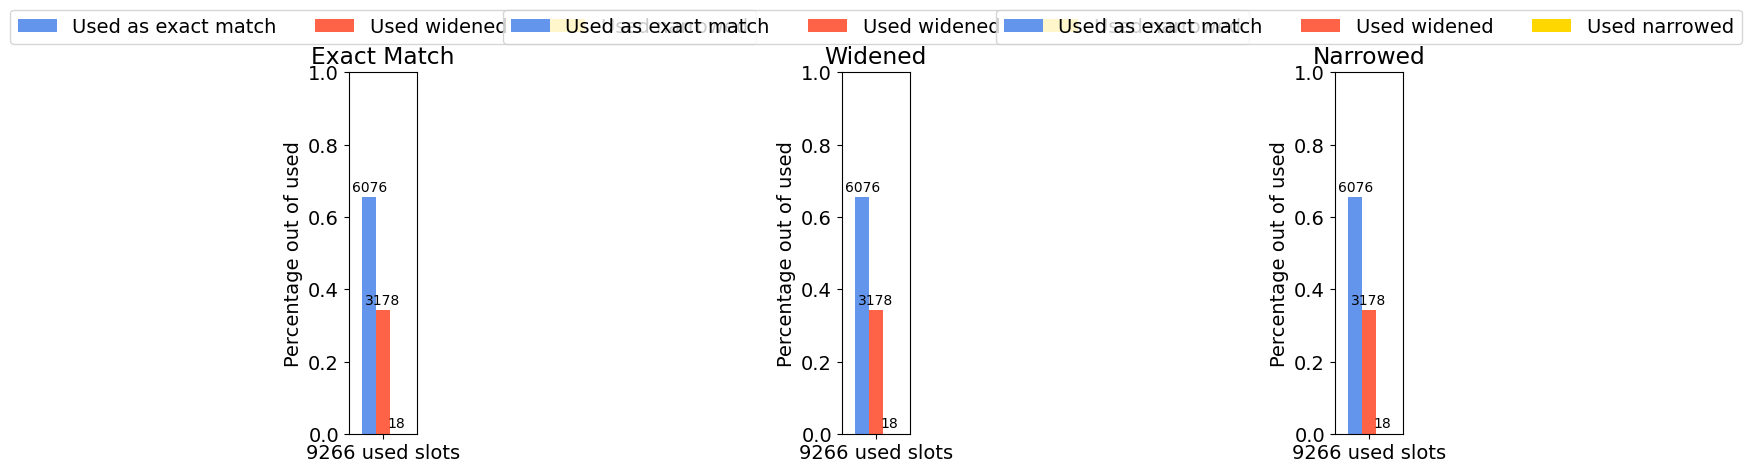

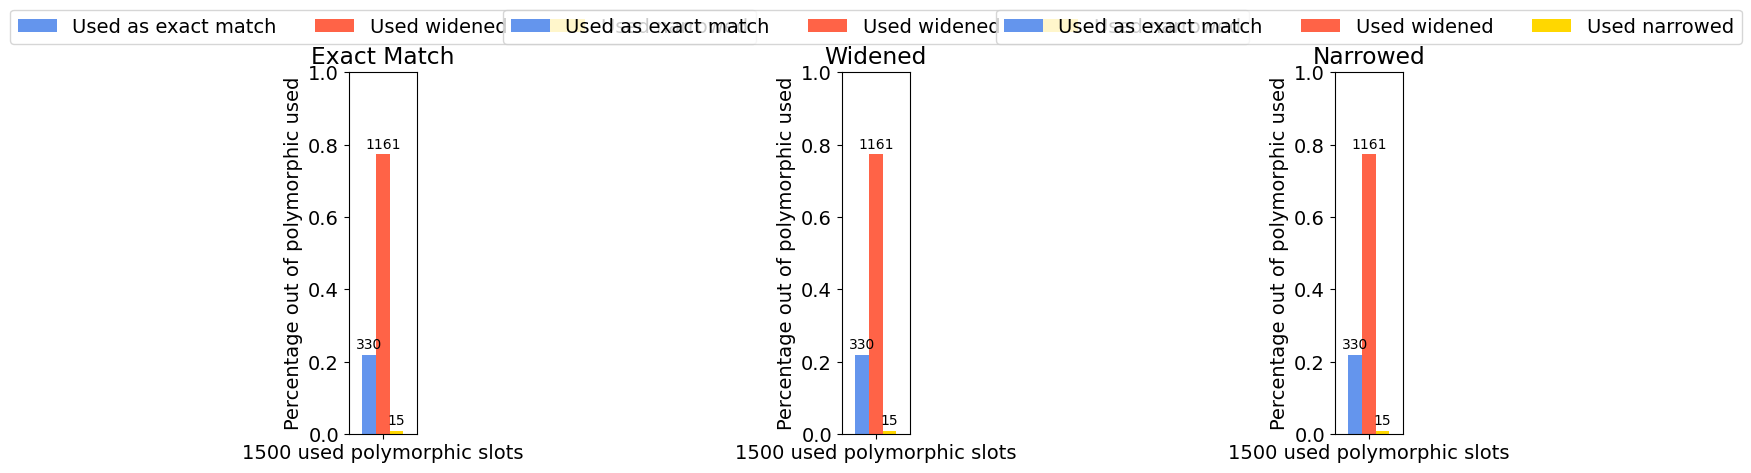

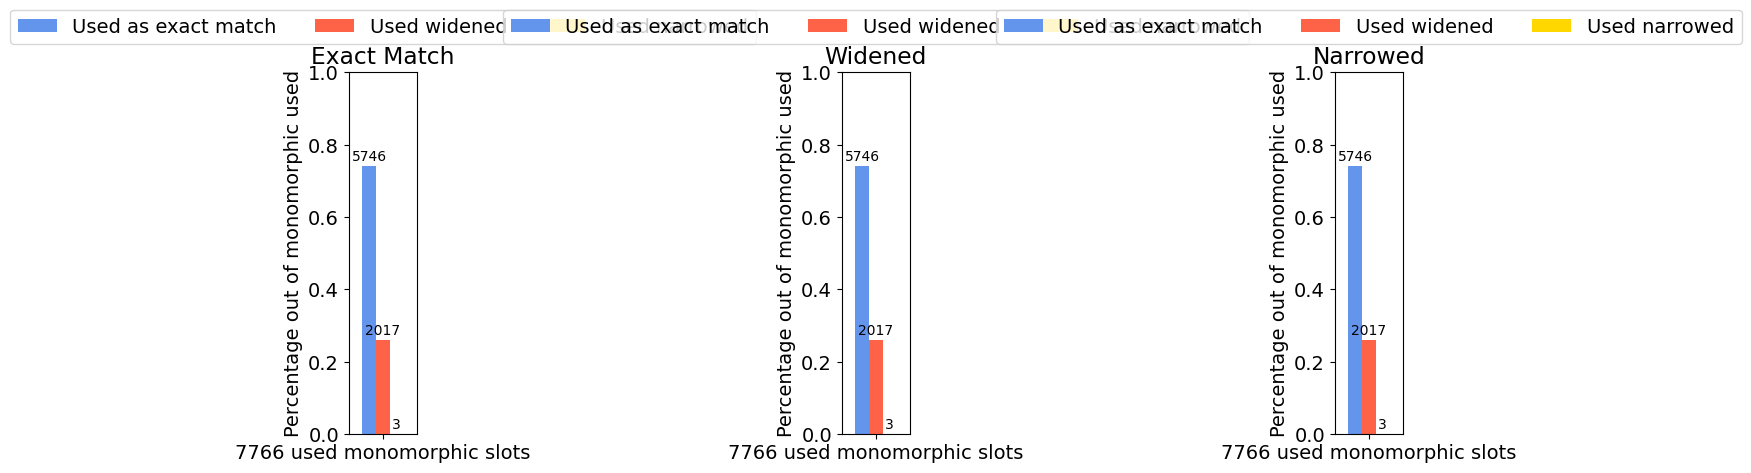

,monomorphic exact match,monomorphic widened,monomorphic narrowed
0,0.739892,0.259722,0.000386


In [ ]:
def plot(df: pd.DataFrame, index, columns=None,
         title=None, filename=None,
         figsize=(15, 5), colors=None,
         labels=None, legend=None,
         xlabel=None, ylabel=None,
         rotate_xticks=True, ax=None):
    if columns is None:
        columns = df.columns
    else:
        df = df[columns]

    df = df.copy()
    df.index = index

    # Use the passed axes (ax) for plotting
    ax = df.plot(
        kind="bar",
        width=0.75,
        figsize=figsize,
        color=colors,
        ax=ax  # Specify the axes for this plot
    )

    if labels == "values":
        labels = [df[col].round(2) for col in columns]

    if labels is not None:
        for container, l in zip(ax.containers, labels):
            ax.bar_label(container, labels=l, label_type="edge", padding=2, fontsize=10)

    if legend is not None:
        ax.legend(legend, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(df.columns))

    if title is not None:
        ax.set_title(title)

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if ylabel is not None:
        ax.set_ylabel(ylabel)

    if rotate_xticks:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    ax.set_ylim(0, 1.0)

    if filename is not None:
        plt.savefig("./figures/" + filename + ".pdf", bbox_inches='tight')

def plot_used(prefix=None):
    cols = ["exact match", "widened", "narrowed"]
    used_col = "used"
    if prefix is not None:
        cols = [prefix + " " + col for col in cols]
        used_col = prefix + " " + used_col

    usg = pd.DataFrame(stats[cols].sum()).T
    used = stats[used_col].sum()
    perc = usg / used

    prefix_str = prefix + " " if prefix is not None else ""

    # Create a single figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot on each of the three subfigures (subplots)
    plot(perc, index=[str(used) + " used " + prefix_str + "slots"],
         colors=colors_used, rotate_xticks=False,
         labels=[usg[col] for col in cols],
         legend=["Used as exact match", "Used widened", "Used narrowed"],
         ylabel="Percentage out of " + prefix_str + "used",
         ax=axs[0], title="Exact Match")

    plot(perc, index=[str(used) + " used " + prefix_str + "slots"],
         colors=colors_used, rotate_xticks=False,
         labels=[usg[col] for col in cols],
         legend=["Used as exact match", "Used widened", "Used narrowed"],
         ylabel="Percentage out of " + prefix_str + "used",
         ax=axs[1], title="Widened")

    plot(perc, index=[str(used) + " used " + prefix_str + "slots"],
         colors=colors_used, rotate_xticks=False,
         labels=[usg[col] for col in cols],
         legend=["Used as exact match", "Used widened", "Used narrowed"],
         ylabel="Percentage out of " + prefix_str + "used",
         ax=axs[2], title="Narrowed")

    # Adjust layout
    plt.tight_layout()

    # if filename is not None:
    #     plt.savefig("./figures/" + filename + ".pdf", bbox_inches='tight')

    plt.show()
    return perc

# Call function for different prefixes
plot_used()
plot_used("polymorphic")
plot_used("monomorphic")

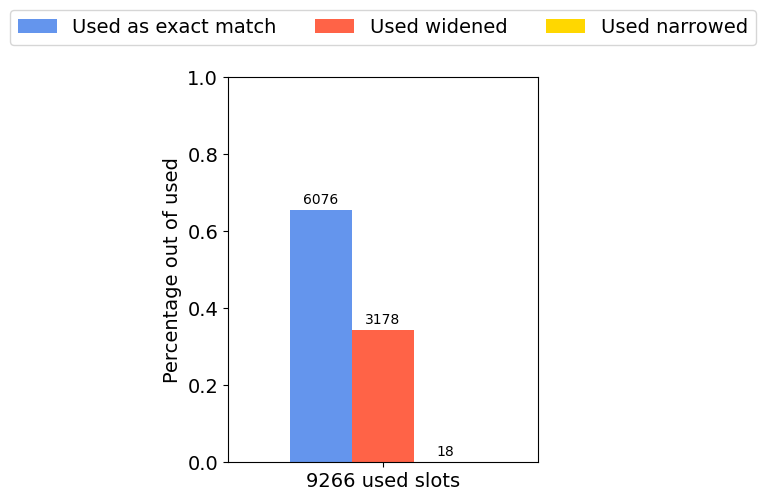

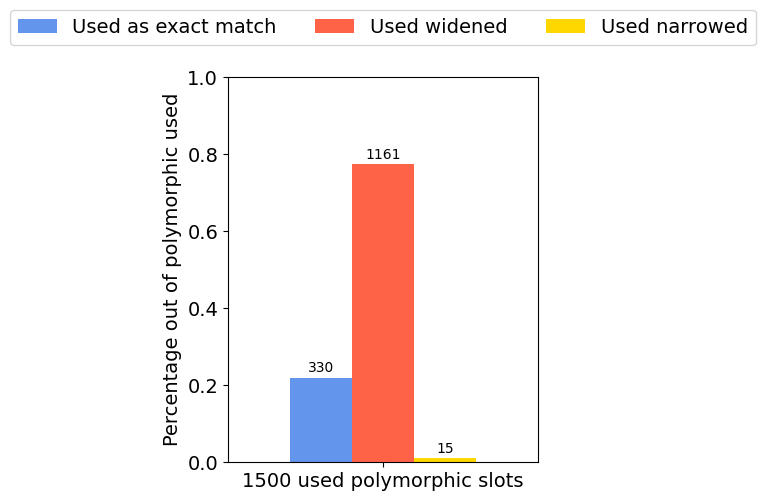

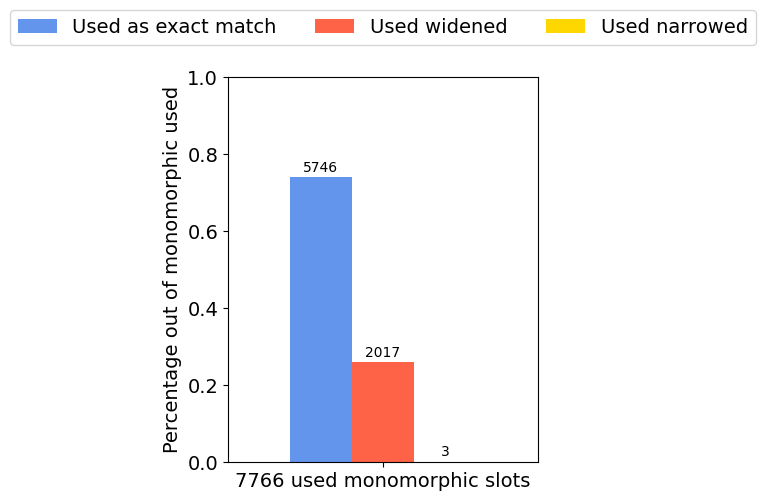

In [ ]:
def plot_used(prefix=None):
    cols = ["exact match", "widened", "narrowed"]
    used_col = "used"
    if prefix is not None:
        cols = [prefix + " " + col for col in cols]
        used_col = prefix + " " + used_col

    usg = pd.DataFrame(stats[cols].sum()).T
    used = stats[used_col].sum()
    perc = usg / used

    prefix_str = prefix + " " if prefix is not None else ""

    plot(
        perc,
        index=[ str(used) + " used " + prefix_str + "slots" ],
        colors=colors_used,

        rotate_xticks=False,
        labels = [usg[col] for col in cols],
        legend = ["Used as exact match", "Used widened", "Used narrowed"],

        ylabel="Percentage out of " + prefix_str + "used",
        figsize=(4, 5),
        filename="used" + ("" if prefix is None else "_" + prefix)
    )

    return perc

used = pd.concat([plot_used(), plot_used("polymorphic"), plot_used("monomorphic")], axis=1)

In [ ]:
# (u_col, u_col_p) = compute_used_percentage()

# plot(df,
#     index = [""],
#     # index=stats.index + "\n(" + stats["used"].astype(str) + " used slots)",
#     # columns=u_col_p,

#     # title="Used slots",

#     colors=colors_used,

#      labels=[u[col] for col in ["exact match", "widened", "narrowed"]],
#     # labels=[ stats[col] for col in u_col ],
#     legend = ["Used as exact match", "Used widened", "Used narrowed"],

#     ylabel="Percentage out of used",
#     filename="used",
#     figsize=(4, 5)
# )

In [ ]:
# (pu_col, pu_col_p) = compute_used_percentage("polymorphic ")

# plot(
#     stats,

#     index=stats.index + "\n(" + stats["polymorphic used"].astype(str) + " used polymorphic slots)",
#     columns=pu_col_p,

#     # title="Used slots",
#     colors=colors_used,
#     figsize=figsize_three_cols,

#     labels=[stats[c] for c in pu_col],
#     legend = ["Polymorphic used as exact match", "Polymorphic used widened", "Polymorphic used narrowed"],

#     ylabel="Percentage out of used polymorphic",
#     filename="used_poly"
# )

In [ ]:
# (mu_col, mu_col_p) = compute_used_percentage("monomorphic ")

# plot(
#     stats,

#     index=stats.index + "\n(" + stats["monomorphic used"].astype(str) + " used monomorphic slots)",
#     columns=mu_col_p,

#     # title="Used slots",
#     colors=colors_used,
#     figsize=figsize_three_cols,

#     labels=[stats[c] for c in mu_col],
#     legend = ["Monomorphic used as exact match", "Monomorphic used widened", "Monomorphic used narrowed"],

#     ylabel="Percentage out of used polymorphic",
#     filename="used_mono"
# )

# Other stats

## Overview

In [ ]:
table = stats[["set", "compilations", "benefited", "referenced"]]
display(table)
table.to_latex('tables/table.tex')

,set,compilations,benefited,referenced
name,,,,
bounce_nonames_simple,areWeFast,11,7,264
mandelbrot,areWeFast,14,9,358
flexclust_no_s4,RealThing,144,95,5402
volcano,RealThing,23,16,2037
binarytrees_naive,shootout,22,13,1070
fannkuchredux,shootout,6,3,251
fannkuchredux_naive,shootout,5,2,244
fasta_naive_2,shootout,17,11,598
knucleotide,shootout,59,33,1493


## Usage

In [ ]:
def m(lhs, rhs = None):
    if rhs is None:
        df = stats[[lhs]]
    else:
        df = pd.DataFrame(agg(lhs, rhs))

    display(df.describe().loc["mean"])

In [ ]:
m("referenced non-empty", "referenced")
m("read non-empty", "referenced non-empty")
m("used", "referenced")
m("used", "referenced non-empty")

referenced non-empty / referenced    0.681745
Name: mean, dtype: float64

read non-empty / referenced non-empty    0.93605
Name: mean, dtype: float64

used / referenced    0.137619
Name: mean, dtype: float64

used / referenced non-empty    0.207859
Name: mean, dtype: float64

In [ ]:
m("read non-empty", "referenced non-empty")

read non-empty / referenced non-empty    0.93605
Name: mean, dtype: float64

## Unused

In [ ]:
for reason in ["optimized away non-empty", "dependent", "other reason unused non-empty"]:
    display("---- " + reason + " ----")
    m(reason, "unused non-empty")
    # m(f"polymorphic {reason}", reason)
    # m(f"monomorphic {reason}", reason)
    m(f"polymorphic {reason}", "polymorphic unused")
    m(f"monomorphic {reason}", "monomorphic unused")

'---- optimized away non-empty ----'

optimized away non-empty / unused non-empty    0.313041
Name: mean, dtype: float64

polymorphic optimized away non-empty / polymorphic unused    0.266468
Name: mean, dtype: float64

monomorphic optimized away non-empty / monomorphic unused    0.332652
Name: mean, dtype: float64

'---- dependent ----'

dependent / unused non-empty    0.594036
Name: mean, dtype: float64

polymorphic dependent / polymorphic unused    0.450429
Name: mean, dtype: float64

monomorphic dependent / monomorphic unused    0.583261
Name: mean, dtype: float64

'---- other reason unused non-empty ----'

other reason unused non-empty / unused non-empty    0.289231
Name: mean, dtype: float64

polymorphic other reason unused non-empty / polymorphic unused    0.389329
Name: mean, dtype: float64

monomorphic other reason unused non-empty / monomorphic unused    0.275696
Name: mean, dtype: float64

In [ ]:
m("optimized away non-empty", "unused non-empty")
m("dependent", "unused non-empty")
m("other reason unused non-empty", "unused non-empty")
m("optimized away dependent", "optimized away non-empty")
m("optimized away dependent", "dependent")
m("optimized away dependent", "unused non-empty")

optimized away non-empty / unused non-empty    0.313041
Name: mean, dtype: float64

dependent / unused non-empty    0.594036
Name: mean, dtype: float64

other reason unused non-empty / unused non-empty    0.289231
Name: mean, dtype: float64

optimized away dependent / optimized away non-empty    0.638378
Name: mean, dtype: float64

optimized away dependent / dependent    0.314793
Name: mean, dtype: float64

optimized away dependent / unused non-empty    0.196308
Name: mean, dtype: float64

In [ ]:
m("polymorphic optimized away non-empty", "polymorphic unused"),
m("polymorphic dependent", "polymorphic unused"),
m("polymorphic other reason unused non-empty", "polymorphic unused")

polymorphic optimized away non-empty / polymorphic unused    0.266468
Name: mean, dtype: float64

polymorphic dependent / polymorphic unused    0.450429
Name: mean, dtype: float64

polymorphic other reason unused non-empty / polymorphic unused    0.389329
Name: mean, dtype: float64

In [ ]:
m("monomorphic dependent", "monomorphic unused"),
m("monomorphic other reason unused non-empty", "monomorphic unused")

monomorphic dependent / monomorphic unused    0.583261
Name: mean, dtype: float64

monomorphic other reason unused non-empty / monomorphic unused    0.275696
Name: mean, dtype: float64

## Used

In [ ]:
stats["narrowed"].sum()

18

In [ ]:
stats["polymorphic exact match"].sum()

330

In [ ]:
# m("exact match %")
# m("widened %")
# m("narrowed %")

# m("monomorphic exact match %")

# m("polymorphic widened %")
# m("polymorphic exact match %")

used

,exact match,widened,narrowed,polymorphic exact match,polymorphic widened,polymorphic narrowed,monomorphic exact match,monomorphic widened,monomorphic narrowed
0,0.655731,0.342974,0.001943,0.22,0.774,0.01,0.739892,0.259722,0.000386


In [ ]:
m("exact match", "used")
m("widened", "used")
m("polymorphic widened", "widened")

exact match / used    0.595345
Name: mean, dtype: float64

widened / used    0.403513
Name: mean, dtype: float64

polymorphic widened / widened    0.551376
Name: mean, dtype: float64

## Polymorphic

In [ ]:
polym = agg("polymorphic widened", "polymorphic used")
display(polym)
display(polym.mean())

name
bounce_nonames_simple    1.000000
mandelbrot               1.000000
flexclust_no_s4          0.806452
volcano                  1.000000
binarytrees_naive        0.918367
fannkuchredux            1.000000
fannkuchredux_naive      1.000000
fasta_naive_2            1.000000
knucleotide              1.000000
pidigits                 0.891974
titanic                  0.694355
Name: polymorphic widened / polymorphic used, dtype: float64

0.9373770801060561

In [ ]:
m("used", "referenced non-empty")
m("polymorphic used", "polymorphic")

used / referenced non-empty    0.207859
Name: mean, dtype: float64

polymorphic used / polymorphic    0.260257
Name: mean, dtype: float64

# Types

In [ ]:
sused = sall[sall["used"] == 1]

In [ ]:
snarrowed = sused[sused["narrowed"] == 1][columns_type + ["polymorphic"]].value_counts().reset_index().sort_values(by=columns_type)
display(snarrowed["count"].sum())
snarrowed

18

,checkForT,staticT,feedbackT,expectedT,requiredT,polymorphic,count
2,int$#-,(int|real)$#-,int$-,int$#-,val?^ | miss,0,3
0,int$-,(int|real)$-,int-,int$-,val?+,1,4
3,real-,real+,(lgl|str)-,-,val?+,1,2
1,val-,val+,val?-,val-,val?+,1,4
6,val-,val+,val?-,val-,val?^ | miss,1,1
4,val?~+,val?^,val?+,val+,val?+,1,2
5,val?~-,val?^,val?-,val-,val?+,1,2


In [ ]:
swidened_poly = sused[sused["polymorphic exact match"] == 1]["feedbackT"].value_counts().reset_index().sort_values(by="feedbackT")
swidened_poly

,feedbackT,count
2,int+,37
0,int-,132
6,lgl+,26
3,lgl-,33
7,real+,3
1,real-,39
5,val?+,30
4,val?-,30


In [ ]:
feed = sall[sall["feedbackT"].notna()][["feedbackT", "polymorphic"]]
objs = feed[ feed["feedbackT"].map(lambda x: "-" not in x and "+" not in x) ]
ps = objs[objs["polymorphic"] == 1]
ms = objs[objs["polymorphic"] == 0]

display(ps.size)
display(ms.size)
display(ps)
display(ms["feedbackT"].unique())
# sall[sall["feedbackT"].notna()]["feedbackT"].map(lambda x: "-" in x or "+" in x)

28

198

,feedbackT,polymorphic
12512,(int|real)_,1
12526,(int|real)_,1
12626,(int|real)_,1
15001,(int|real)_,1
15015,(int|real)_,1
15115,(int|real)_,1
64319,(lgl|real)_,1
65734,(real|str)_,1
68068,val?_,1
75571,val?_,1


array(['str_', 'real_', 'lgl_', 'int_'], dtype=object)